Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
#from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
import matplotlib.pyplot as plt
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
import time
%matplotlib inline

Download the data from the source website if necessary.
-----------

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urllib.urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print 'Found and verified', filename
  else:
    print statinfo.st_size
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


**Read the data into a string.**

In [4]:
def read_data(filename):
  f = zipfile.ZipFile(filename)
  for name in f.namelist():
    print name, type(name)
    return f.read(name).split()
  f.close()
  
words = read_data(filename)
print 'Data size', len(words)

text8 <type 'str'>
Data size 17005207


** Build the dictionary and replace rare words with UNK token.**

In [5]:
## exclude words in stoplist
stoplist = set('for a b c d e f g h i j k l m n o p q r s t u v w x y z \
    an th the'.split())

In [6]:
words = [i for i in words if i not in stoplist]
print 'Data size', len(words)

Data size 15117753


In [7]:
vocabulary_size = 50000  # orig 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print 'Most common words (+UNK):'
print count[:15]
print 'Sample data (indexes of words):'
print data[:10]  # 
del words  # Hint to reduce memory.

Most common words (+UNK):
[['UNK', 418121], ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('to', 316376), ('zero', 264975), ('nine', 250430), ('two', 192644), ('is', 183153), ('as', 131815), ('eight', 125285), ('five', 115789), ('three', 114775), ('was', 112807)]
Sample data (indexes of words):
[5209, 3054, 10, 177, 1, 3107, 41, 54, 140, 115]


### Look at the data

In [7]:
print len(data), data[-10:]
print len(count), count[-10:]

15117753 [13987, 4, 3, 7, 18, 13, 3, 7, 18, 12]
50000 [('myelogenous', 9), ('gyre', 9), ('beckenbauer', 9), ('ulbricht', 9), ('quartermaster', 9), ('guericke', 9), ('creams', 9), ('yetzer', 9), ('vasoconstriction', 9), ('lockhart', 9)]


In [8]:
# begining of corpus, with indexes
for i in (data)[:10]:
    print reverse_dictionary[i], i

anarchism 5209
originated 3054
as 10
term 177
of 1
abuse 3107
first 41
used 54
against 140
early 115


In [9]:
# end of corpus, with indexes
for i in (data)[-20:]:
    print reverse_dictionary[i], i

masada 28111
was 14
identified 1729
in 4
one 3
eight 11
four 17
two 8
and 2
extensively 3937
excavated 13987
in 4
one 3
nine 7
six 18
three 13
one 3
nine 7
six 18
five 12


In [10]:
for i in dictionary.keys()[-5:]:
    print i, dictionary[i]

rotting 26417
pods 23251
emery 40147
northerly 23607
expands 14467


In [11]:
for i in reverse_dictionary.items()[:11]:
    print i

(0, 'UNK')
(1, 'of')
(2, 'and')
(3, 'one')
(4, 'in')
(5, 'to')
(6, 'zero')
(7, 'nine')
(8, 'two')
(9, 'is')
(10, 'as')


Function to generate a training batch for the skip-gram model.
----------

In [169]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size / num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

''' original print statements
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print batch[i], '->', labels[i, 0]
  print reverse_dictionary[batch[i]], '->', reverse_dictionary[labels[i, 0]]
'''

print('data:'),[reverse_dictionary[di] for di in data[:8]]

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:') % (num_skips, skip_window)
    print '    batch:', [reverse_dictionary[bi] for bi in batch]
    print '    labels:', [reverse_dictionary[li] for li in labels.reshape(8)]

data: ['anarchism', 'originated', 'as', 'term', 'of', 'abuse', 'first', 'used']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'term', 'term', 'of', 'of']
    labels: ['as', 'anarchism', 'originated', 'term', 'as', 'of', 'term', 'abuse']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'term', 'term', 'term', 'term']
    labels: ['anarchism', 'originated', 'term', 'of', 'originated', 'as', 'of', 'abuse']


## Train a skip-gram model.


In [42]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(100,valid_window+100), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)  ## 16 random from top 100
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  print embed.get_shape().as_list()
  # Compute the softmax loss, using a sample of the negative labels each time.
  # https://www.tensorflow.org/versions/0.6.0/api_docs/python/nn.html#sampled_softmax_loss
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))
  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

[128, 128]


### Run the skip-gram model

In [43]:
num_steps = 100001  # 100001

t0 = time.time()
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print "Initialized in {} secs\n=========".format(time.time()-t0)
  average_loss = 0
  for step in xrange(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, lz = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += lz
    if step % 5000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print "Average loss at step", step, ":", average_loss
      print "----------------------"
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 20000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 4 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = "Nearest to %s:" % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = "%s %s," % (log, close_word)
        print log
  final_embeddings = normalized_embeddings.eval()
# show how much time elapsed
print (time.time()-t0)/60., 'minutes elapsed'

Initialized in 0.203025102615 secs
Average loss at step 0 : 7.98127698898
----------------------
Nearest to british: gigi, sinless, rabbani, eurystheus,
Nearest to much: hawick, multi, mediating, sz,
Nearest to do: analysts, armistice, bacterium, ro,
Nearest to military: writs, woodside, parentheses, nne,
Nearest to second: rational, antitrust, nascent, threaded,
Nearest to made: keen, provocation, swordsmanship, sitcom,
Nearest to early: navigational, stoves, acth, broth,
Nearest to common: gregory, clubs, rarefied, acquis,
Nearest to through: wildlife, gottwald, isomorphisms, colonia,
Nearest to we: coals, molten, protists, fantasy,
Nearest to those: sanskrit, dustin, carlton, glencoe,
Nearest to party: callers, beos, canola, evangelion,
Nearest to work: sectional, nord, mech, butch,
Nearest to music: myst, bleachers, equiv, kzin,
Nearest to another: post, hagia, pediatrics, fernandez,
Nearest to she: artaxerxes, adjoined, isambard, cosmologies,
Average loss at step 5000 : 10.3322380

### Look at embeddings


In [19]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

In [20]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in xrange(1, num_points+1)]

In [21]:
print(plt.style.available)

[u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn-dark-palette']


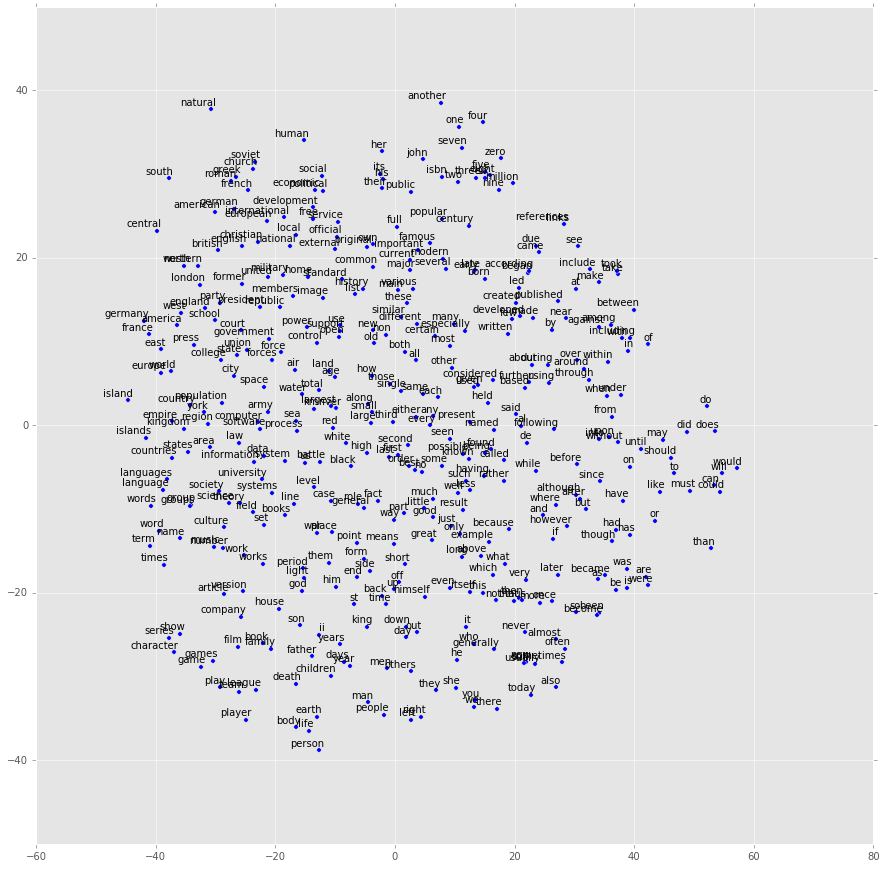

In [22]:
plt.style.use('ggplot')
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to Word2Vec is called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

> 3.1    Continuous Bag-of-Words Model

>The first proposed architecture is similar to the feedforward NNLM, where the non-linear hiddenlayer is removed and the projection layer is shared for all words (not just the projection matrix);thus, all words get projected into the same position (their vectors are averaged). 

>We call this archi-tecture a bag-of-words model as the order of words in the history does not influence the projection. Furthermore, we also use words from the future.

>We have obtained the best performance on the task introduced in the next section by building a **log-linear classifier with four future and four history words at the input**, where the training criterion is to correctly **classify the current (middle) word**.

>Training complexity is then 

>`Q = N*D + D*log2(V)`
    
>We denote this model further as CBOW, as unlike standard bag-of-words model, it uses continuousdistributed representation of the context. The model architecture is shown at Figure 1. Note that theweight matrix between the input and the projection layer is shared for all word positions in the sameway as in the NNLM.

Generate training batch for CBOW
----------

In [193]:
data_index = 0

# keep batch size
def gen_batch_cbow(batch_size, bag_window):
  global data_index
  span = 2 * bag_window + 1 # [ bag_window target bag_window ]
  assert batch_size >= span
  batch = np.ndarray(shape=(batch_size, span-1), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  buffer = collections.deque(maxlen=1)
  buffer.append(data[data_index:data_index+span])    
  #print buffer
  data_index = (data_index + 1) % len(data)
  ## loop through batch size and update batch, labels
  for i in range(batch_size):
    batch[i,0:bag_window] = buffer[0][0:bag_window] # grab words left of target
    labels[i] = buffer[0][bag_window]  # grab target
    batch[i,bag_window:] = buffer[0][bag_window+1:]  # grab words right of target
    buffer.append(data[data_index:data_index+span])  # gen next buffer
    #print buffer
    data_index = (data_index + 1) % len(data)
    
  return np.array(batch, dtype=np.int32), np.array(labels, dtype=np.int32)

batch, labels = gen_batch_cbow(batch_size=6, bag_window=2)
print batch.shape, '\n----'

for i in range(2):
  print batch[i], '->', labels[i, 0]
  for j in batch[i]:
    print(reverse_dictionary[j])
  print'->', reverse_dictionary[labels[i, 0]]
  print('-'*16)

(6, 4) 
----
[5209 3054  177    1] -> 10
anarchism
originated
term
of
-> as
----------------
[3054   10    1 3107] -> 177
originated
as
of
abuse
-> term
----------------


** Building the graph, CBOW **

In [194]:
batch_size = 128
bag_window = 1 # How many words to consider left and right.
embedding_size = 128 # Dimension of the embedding vector.

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
''' Use same validation examples as above
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.

valid_examples = np.array(random.sample(xrange(1,valid_window), valid_size))
'''
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, 2*bag_window])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Model.
  sum_embed = tf.reduce_mean(tf.nn.embedding_lookup(embeddings, train_dataset), 1)
  print(sum_embed.get_shape().as_list())
  
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, sum_embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Optimizer, gradient descent
  #global_step = tf.Variable(0) # count the number of steps taken.
  #learning_rate = tf.train.exponential_decay(1.0, global_step, 6000, 0.8, staircase=True)
  #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

[128, 128]


** Run it, CBOW **

In [195]:
num_steps = 100001  # 100001

t0 = time.time()
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print "Initialized in {} seconds".format(time.time()-t0)
  print("="*16)
  average_loss = 0
  for step in xrange(num_steps):
    batch_data, batch_labels = gen_batch_cbow(batch_size, bag_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, lz = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += lz
    if step % 5000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print "Average loss at step", step, ":", average_loss
      print("-"*16) 
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 20000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 4 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = "Nearest to %s:" % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = "%s %s," % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()
# show how much time elapsed
print (time.time()-t0)/60., 'minutes elapsed'

Initialized in 0.189354896545 seconds
Average loss at step 0 : 7.41660499573
----------------
Nearest to british: socks, melanoleuca, noticing, plectrum,
Nearest to much: deptford, zh, cheated, brigadists,
Nearest to do: chester, hume, philo, nica,
Nearest to military: manu, ouagadougou, protect, uncharacteristic,
Nearest to second: diatessaron, cie, prospective, weasel,
Nearest to made: bourbaki, fayed, oren, petty,
Nearest to early: majors, redundancy, justifying, colossus,
Nearest to common: sukkot, marsden, castilla, financi,
Nearest to through: hammerhead, taoiseach, maggiore, polish,
Nearest to we: karloff, bullpen, hawaiian, assistants,
Nearest to those: dangling, camelopardalis, traitors, magnesians,
Nearest to party: vagaries, mayfield, rotterdam, provisioning,
Nearest to work: disappearances, matejko, costanza, jarvis,
Nearest to music: compact, subscripts, symmetrically, consolidating,
Nearest to another: caenorhabditis, amara, hurrian, claw,
Nearest to she: penning, board, 

Compare to Skip-gram model:

    Nearest to british: american, french, german, russian,
    Nearest to much: far, little, than, many,
    Nearest to do: did, does, tend, include,
    Nearest to military: defense, army, devoured, financial,
    Nearest to second: third, first, last, fourth,
    Nearest to made: built, produced, gave, encouraged,
    Nearest to early: late, recent, mid, later,
    Nearest to common: popular, prominent, important, specific,
    Nearest to through: into, from, by, across,
    Nearest to we: you, they, there, she,
    Nearest to those: these, people, women, many,
    Nearest to party: parties, yx, florin, government,
    Nearest to work: works, life, influence, success,
    Nearest to music: masoretic, art, dance, culture,
    Nearest to another: single, any, flip, wirth,
    Nearest to she: he, it, they, there,
    9.29702796539 minutes elapsed

** Look at embedding in 2D**

In [196]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

In [197]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

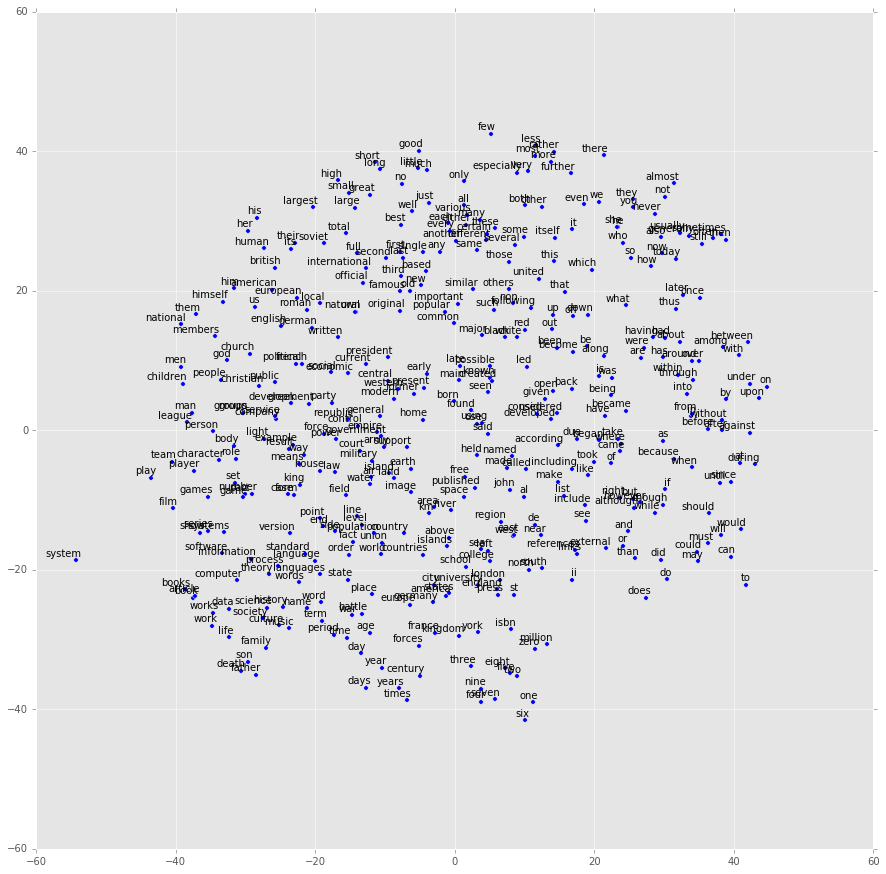

In [198]:
words = [reverse_dictionary[i] for i in xrange(1, num_points+1)]
plot(two_d_embeddings, words)

---

Scratchpad
----------

In [ ]:
  ## split input data to look up embeddings
  ## possible issue with possible issue with >1 dim embedding lookup
  ## https://github.com/tensorflow/tensorflow/issues/505
  _emb = []                                                                                                                 
  for x in tf.split(1, 2*bag_window, train_dataset):
    buffer = tf.Variable(tf.zeros([embedding_size]))
    emb = tf.nn.embedding_lookup(embeddings, x)
    print emb.get_shape().as_list()
    _emb.append(emb)
  embed = tf.concat(1, _emb)
  print embed.get_shape().as_list()
  sum_embed = tf.reduce_mean(embed, 1)
  print sum_embed.get_shape().as_list()